In [1]:
import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

### List of CPU and GPUs
How to get list of CPU and GPUs ?

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
get_available_gpus()

[u'/cpu:0',
 u'/gpu:0',
 u'/gpu:1',
 u'/gpu:2',
 u'/gpu:3',
 u'/device:XLA_GPU:0',
 u'/device:XLA_CPU:0']

What is __XLA__?
XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear algebra that optimizes TensorFlow computations. The results are improvements in speed, memory usage, and portability on server and mobile platforms. Initially, most users will not see large benefits from XLA, but are welcome to experiment by using XLA via just-in-time (JIT) compilation or ahead-of-time (AOT) compilation. Developers targeting new hardware accelerators are especially encouraged to try out XLA.

The XLA framework is experimental and in active development. In particular, while it is unlikely that the semantics of existing operations will change, it is expected that more operations will be added to cover important use cases. The team welcomes feedback from the community about missing functionality and community contributions via GitHub.

### Logging device

I also recommend logging device placement when using GPUs, at this lets you easily debug issues relating to different device usage. This prints the usage of devices to the log, allowing you to see when devices change and how that affects the graph.

You can see that a, b and c are all run on GPU0

### ***Run it in a terminal***

In [3]:
def print_logging_device():
    # Creates a graph.
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    # Creates a session with log_device_placement set to True.
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    print sess.run(c)
print_logging_device()

[[ 22.  28.]
 [ 49.  64.]]


### Multiplication on gpu0 and cpu

In [6]:
print "------- Multiplication on gpu0 vs cpu ---------"
def matrix_mul(device_name, matrix_sizes):
    time_values = []
    #device_name = "/cpu:0"
    for size in matrix_sizes:
        with tf.device(device_name):
            random_matrix = tf.random_uniform(shape=(2,2), minval=0, maxval=1)
            dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
            sum_operation = tf.reduce_sum(dot_operation)

        with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as session:
            startTime = datetime.now()
            result = session.run(sum_operation)
        td = datetime.now() - startTime
        time_values.append(td.microseconds/1000)
        print ("matrix shape:" + str(size) + "  --"+ device_name +" time: "+str(td.microseconds/1000))
    return time_values


matrix_sizes = range(100,1000,100)
time_values_gpu = matrix_mul("/gpu:0", matrix_sizes)
time_values_cpu = matrix_mul("/cpu:0", matrix_sizes)
print ("GPU time" +  str(time_values_gpu))
print ("CPUtime" + str(time_values_cpu))
print "--------------------------------"


------- Multiplication on gpu0 vs cpu ---------
matrix shape:100  --/gpu:0 time: 97
matrix shape:200  --/gpu:0 time: 108
matrix shape:300  --/gpu:0 time: 105
matrix shape:400  --/gpu:0 time: 123
matrix shape:500  --/gpu:0 time: 124
matrix shape:600  --/gpu:0 time: 181
matrix shape:700  --/gpu:0 time: 133
matrix shape:800  --/gpu:0 time: 152
matrix shape:900  --/gpu:0 time: 137
matrix shape:100  --/cpu:0 time: 143
matrix shape:200  --/cpu:0 time: 142
matrix shape:300  --/cpu:0 time: 289
matrix shape:400  --/cpu:0 time: 162
matrix shape:500  --/cpu:0 time: 165
matrix shape:600  --/cpu:0 time: 176
matrix shape:700  --/cpu:0 time: 168
matrix shape:800  --/cpu:0 time: 224
matrix shape:900  --/cpu:0 time: 176
GPU time[97, 108, 105, 123, 124, 181, 133, 152, 137]
CPUtime[143, 142, 289, 162, 165, 176, 168, 224, 176]
--------------------------------


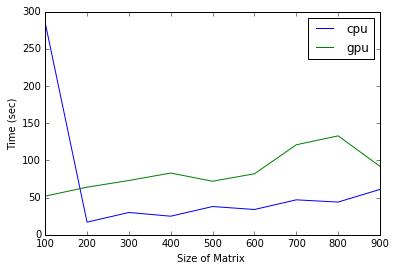

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(matrix_sizes[:len(time_values_gpu)], time_values_gpu, label='cpu')
plt.plot(matrix_sizes[:len(time_values_cpu)], time_values_cpu, label='gpu')
plt.ylabel('Time (sec)')
plt.xlabel('Size of Matrix ')
plt.legend(loc='best')
plt.show()

# Using Multi GPUs

In [6]:
print "------- Multi GPU ---------"
def multi_gpu():
    c = []
    for d in ['/cpu','/gpu:0', '/gpu:1','/gpu:2', '/gpu:3']:
      with tf.device(d):
        a = tf.ones(shape=[3,3], dtype=tf.float32)
        b = tf.ones(shape=[3,3], dtype=tf.float32)
        c.append(tf.matmul(a, b))
    with tf.device('/cpu:0'):
      sum = tf.add_n(c)
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    print(sess.run(sum))
    
multi_gpu()
print "--------------------------------"

------- Multi GPU ---------
[[ 15.  15.  15.]
 [ 15.  15.  15.]
 [ 15.  15.  15.]]
--------------------------------


# Single vs Multi GPU

taken from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/5_MultiGPU/multigpu_basics.py

In [2]:
def single_gpu_sum(matrix_size ,n):
    
    # Create a graph to store results
    comp = []

    def matpow(M, n):
        if n < 1: 
            return M
        else:
            return tf.matmul(M, matpow(M, n-1))

    for d in ['/gpu:0', '/gpu:1','/gpu:2', '/gpu:3']:
        with tf.device('/gpu:0'):
            A = np.random.rand(matrix_size, matrix_size).astype('float32')
        
            # Compute A^n and B^n and store results in c1
            comp.append(matpow(A, n))

    with tf.device('/cpu:0'):
      sum = tf.add_n(comp) #Addition of all elements in c1, i.e. A^n + B^n

    startTime = datetime.now()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(sum)
    td = datetime.now() - startTime
    #print ("n:" + str(n) + "  -- time: "+str(td))
    return td

In [3]:
def multi_gpu_sum(matrix_size ,n):
    
    # Create a graph to store results
    comp = []

    def matpow(M, n):
        if n < 1: 
            return M
        else:
            return tf.matmul(M, matpow(M, n-1))
        
    for d in ['/gpu:0', '/gpu:1','/gpu:2', '/gpu:3']:
        with tf.device(d):
            A = np.random.rand(matrix_size, matrix_size).astype('float32')
            comp.append(matpow(A, n))

    with tf.device('/cpu:0'):
      sum = tf.add_n(comp) #Addition of all elements in c1, i.e. A^n + B^n

    startTime = datetime.now()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(sum)
    td = datetime.now() - startTime
    #print ("n:" + str(n) + "  -- time: "+str(td))
    return td
    


In [7]:
single_gpu = str(single_gpu_sum(1000 ,10))
multi_gpu = str(multi_gpu_sum(1000 ,10))
print single_gpu
print multi_gpu

0:00:01.539578
0:00:01.664352


### Questions:

Which operations can be performed on a GPU, and which cannot?